<div style="text-align: right">NLP Research, Spring 2022</div>
<div style="text-align: right">Dino Konstantopoulos, 4 March 2022</div>

# Knowledge graph on thinned-out Mao

We trim Mao sentences using a BERT-norm litmus test, then we build a knowledge graph using `networkX`.

The reason we want a knowlede graph is to encode in a compact representation what Mao is saying. Indeed, a trained chatbot is just a probabilistic database from things people wrote on the World Wide Web. Based on previous context, it finds the most popular segue. But we don't want to segue into something that Mao does *not* believe in.

# 1. Text corpora
I harvested 6 of Mao's writings from [here](https://www.marxists.org/reference/archive/mao/selected-works/index.htm).

In [1]:
import os
for root, dirs, files in os.walk("c:/Users/Dino/mao"):
    for file in files:
        if file.endswith(".txt"):
             print(os.path.join(root, file))

c:/Users/Dino/mao\A SINGLE SPARK CAN START A PRAIRIE FIRE.txt
c:/Users/Dino/mao\ANALYSIS OF THE CLASSES IN CHINESE SOCIETY.txt
c:/Users/Dino/mao\BE CONCERNED WITH THE WELL-BEING OF THE MASSES, PAY ATTENTION TO METHODS OF WORK.txt
c:/Users/Dino/mao\ON CORRECTING MISTAKEN IDEAS IN THE PARTY.txt
c:/Users/Dino/mao\REPORT ON AN INVESTIGATION OF THE PEASANT MOVEMENT IN HUNAN.txt
c:/Users/Dino/mao\WHY IS IT THAT RED POLITICAL POWER CAN EXIST IN CHINA.txt


These are the paragraphs, and this is the first one below:

In [2]:
import os
mao_paragraphs = []
for root, dirs, files in os.walk("c:/Users/Dino/mao"):
    for file in files:
        if file.endswith(".txt"):
            print(os.path.join(root, file))
            with open(os.path.join(root, file), "r") as input:
                paragraphs = input.read().split("\n\n")   #\n\n denotes there is a blank line in between paragraphs.
            #print(paragraphs[0])
            mao_paragraphs.extend(paragraphs)
            
print(len(mao_paragraphs))
print(mao_paragraphs[0])

c:/Users/Dino/mao\A SINGLE SPARK CAN START A PRAIRIE FIRE.txt
c:/Users/Dino/mao\ANALYSIS OF THE CLASSES IN CHINESE SOCIETY.txt
c:/Users/Dino/mao\BE CONCERNED WITH THE WELL-BEING OF THE MASSES, PAY ATTENTION TO METHODS OF WORK.txt
c:/Users/Dino/mao\ON CORRECTING MISTAKEN IDEAS IN THE PARTY.txt
c:/Users/Dino/mao\REPORT ON AN INVESTIGATION OF THE PEASANT MOVEMENT IN HUNAN.txt
c:/Users/Dino/mao\WHY IS IT THAT RED POLITICAL POWER CAN EXIST IN CHINA.txt
202
Some comrades in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to take. Though they believe that a revolutionary high tide is inevitable, they do not believe it to be imminent. Therefore, they disapprove of the plan to take Kiangsi and only approve of roving guerrilla actions in the three areas on the borders of Fukien, Kwangtung and Kiangsi; at the same time, as they do not have a deep understanding of what it means to establish Red political power in t

We see that we have about 200 paragraphs and that the first paragraph is kind of looooooooooooooooooooong. Also, Mao tends to write 
long sentences. So, let's stick to sentences instead:

In [3]:
import os
mao_sentences = []
for root, dirs, files in os.walk("c:/Users/Dino/mao"):
    for file in files:
        if file.endswith(".txt"):
            print(os.path.join(root, file))
            with open(os.path.join(root, file), "r") as input:
                sentences = input.read().split(". ")   #. denotes end of sentence
            mao_sentences.extend(sentences)
            
print(len(mao_sentences))
print(mao_sentences[0])

c:/Users/Dino/mao\A SINGLE SPARK CAN START A PRAIRIE FIRE.txt
c:/Users/Dino/mao\ANALYSIS OF THE CLASSES IN CHINESE SOCIETY.txt
c:/Users/Dino/mao\BE CONCERNED WITH THE WELL-BEING OF THE MASSES, PAY ATTENTION TO METHODS OF WORK.txt
c:/Users/Dino/mao\ON CORRECTING MISTAKEN IDEAS IN THE PARTY.txt
c:/Users/Dino/mao\REPORT ON AN INVESTIGATION OF THE PEASANT MOVEMENT IN HUNAN.txt
c:/Users/Dino/mao\WHY IS IT THAT RED POLITICAL POWER CAN EXIST IN CHINA.txt
966
Some comrades in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to take


So we have about 1,000 sentences. Let's do some exploratory data analysis (EDA) so that we have all the intuitions about what our sentences contain. Let’s create a column that contains the length of each sentence to get an idea about the average number of words used in a sentence.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

mao_df = pd.DataFrame(mao_sentences, columns = ['Sentence'])
mao_df.head()

d:\Anaconda3.5.1\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Sentence
0,Some comrades in our Party still do not know h...
1,Though they believe that a revolutionary high ...
2,"Therefore, they disapprove of the plan to take..."
3,"They seem to think that, since the revolutiona..."
4,"Instead, they want to extend our political inf..."


Text(0.5, 1.0, 'Distribution of number of words in each sentence')

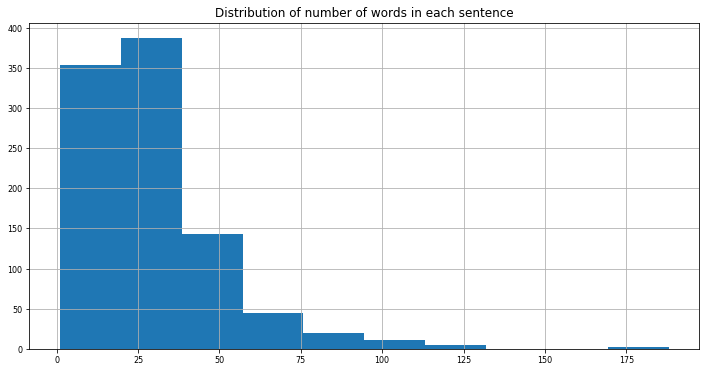

In [5]:
mao_df['NumWords'] = mao_df['Sentence'].apply(lambda x: len(x.split()))
mao_df[['NumWords']].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distribution of number of words in each sentence")

Wow, 25 words on average! Now, let's build a word cloud to see the most frequent words. 

In [6]:
all_words = ''.join([word for word in mao_df['Sentence']]).replace('\n', ' ')
all_words[0:1000]

'Some comrades in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to takeThough they believe that a revolutionary high tide is inevitable, they do not believe it to be imminentTherefore, they disapprove of the plan to take Kiangsi and only approve of roving guerrilla actions in the three areas on the borders of Fukien, Kwangtung and Kiangsi; at the same time, as they do not have a deep understanding of what it means to establish Red political power in the guerrilla areas, they do not have a deep understanding of the idea of accelerating the nation-wide revolutionary high tide through the consolidation and expansion of Red political powerThey seem to think that, since the revolutionary high tide is still remote, it will be labour lost to attempt to establish political power by hard workInstead, they want to extend our political influence through the easier method of roving guerrilla actions, and, once th

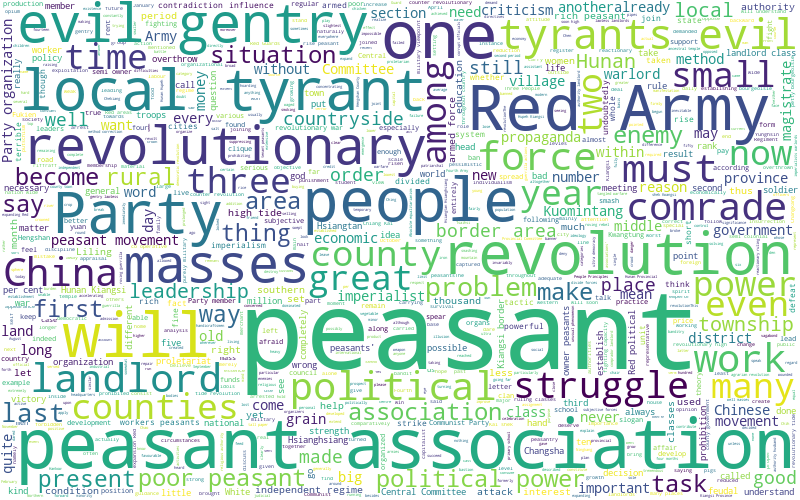

In [7]:
from wordcloud import WordCloud

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=500, max_font_size=110, background_color="white", max_words=3000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(all_words)

# Visualize the word cloud
wordcloud.to_image()

Let's do some cleaning operations like turning all words to lowercase, remove punctuation and non-ASCII characters which are irrelevant for modeling topics.

In [8]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = ''
    lower = texts.lower()
    no_punctuation = NON_ALPHANUM.sub(r' ', lower)
    no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
    return no_non_ascii
  
mao_df['Sentence2'] = mao_df['Sentence'].apply(normalize_texts)
mao_df.head()
mao_df['Sentence2'] = mao_df['Sentence2'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

Top 30 words used with their frequencies:

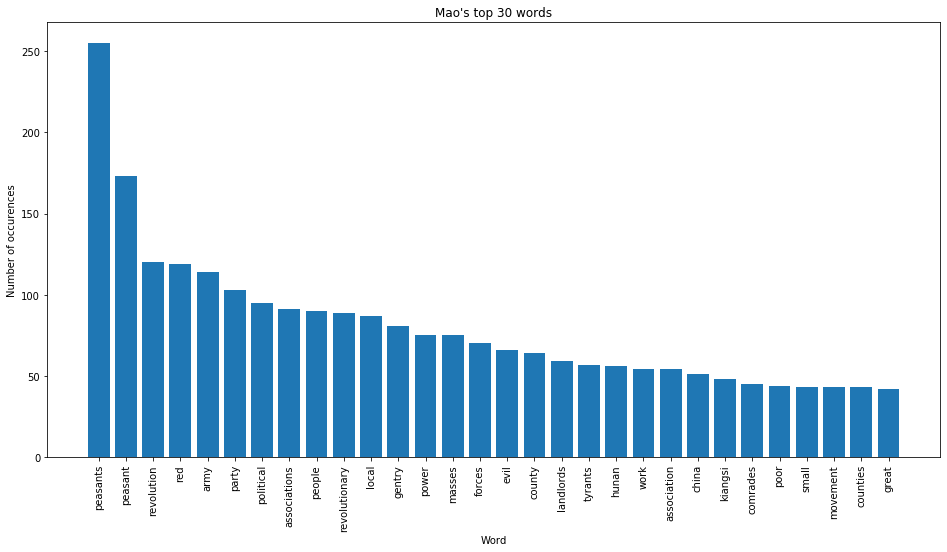

In [9]:
def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words = []
word_values = []
for i,j in get_top_n_words(mao_df['Sentence2'], 30):
    words.append(i)
    word_values.append(j)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title("Mao's top 30 words");
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Some interesting conclusions: We also need to **stem** words so that `peasants` and `peasant` represents the same occurrence. Also, some words needs to be grouped into bigrams, such as `red army`.

These sentences do appear to be central sentences in Mao's thinking.

Then we can assign each sentence to its cluster, and for each cluster get the cosine distance between
any sentence and any other sentences in the cluster. We can then pick the sentence closest to the *imaginary* (theoretic) cluster centroid, or the sentence with the lowest sum of cosine distances with all other sentences. We can then assume that this sentence is the *real* centroid of the cluster.

We can also remove sentences that don't have too much meaning. Nan tried using a Bayesian based anti-spam filter for that, which I think is a very ingenious idea.

# 2. BERT Embeddings

Let's not forget that BERT vectors can be used as high-quality feature inputs to downstream models. 

NLP models such as LSTMs or CNNs require inputs in the form of numerical vectors, and this typically means translating features like the vocabulary and parts of speech into numerical representations. In the past, words have been represented either as uniquely indexed values (one-hot encoding), or even better as neural word embeddings where vocabulary words are matched against the fixed-length feature embeddings that result from models like Word2Vec. 

BERT offers an advantage over models like Word2Vec, because with Word2vec each word has a fixed representation regardless of the context within which the word appears. In contrast, BERT produces word representations that are dynamically informed by the words around them (the context).

For example, given two sentences:

“The man was accused of robbing a bank.” “The man went fishing by the bank of the river.”

Word2Vec would produce the same word embedding for the word “bank” in both sentences, while under BERT the word embedding for “bank” would be different for each sentence. Aside from capturing obvious differences like polysemy, the context-informed word embeddings capture other forms of information that result in more accurate feature representations, which in turn results in better model performance.

Let's order mao's sentences by their norms to see what we get. The cell below takes about 1 mn. to run and will take up about 2Gigs of your hard disk space to cache the Transformer model! The code is **memory-bound**.

In [10]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('stsb-roberta-large')

Let's compute the BERT embeddings for Mao's sentences. The code cell below won't take too much disk space, but it will take about 5 mns to run. It's **CPU-bound**. You *will* hear your laptop's CPU revving up, kinda like a sportscar. *Vroom vroom, motorino!*

In [11]:
bert_embeddings = model.encode(mao_sentences)
bert_embeddings.shape

(966, 1024)

With word2vec, the norm of the vector decreases as the word is used in more varied contexts. So, stopwords are close to 0 while very unique and high meaning words tend to be *large* vectors. BERT is context sensitive, so this explanation doesn't entirely fit BERT embeddings.
 
Let's see how the BERT norms behave with mao:

In [12]:
import numpy as np
v1 = np.arange(9.0).reshape((3, 3))
v1

array([[0., 1., 2.],
       [3., 4., 5.],
       [6., 7., 8.]])

In [13]:
v1.shape

(3, 3)

This is how we compute the norms of each vector formed by a row of the matrix above:

In [14]:
for i in range(0, 3):
    print(np.sqrt(np.dot(v1[i], v1[i])))

2.23606797749979
7.0710678118654755
12.206555615733702


Let's compute the norms of our BERT embeddings:

In [15]:
bert_norms = []
for i in range(0, 966):
    bert_norms.append(np.sqrt(np.dot(bert_embeddings[i], bert_embeddings[i])))

Let's index them:

In [16]:
bert_norms_dict = dict()
for i in range(0, 966):
    bert_norms_dict[i] = bert_norms[i]

# 3. Remove nonsensical sentences using hybrid means
We will use both synatctic (classical) and semantic (BERT-norm based) techniques to prune sentences that re not too important in Mao's writings.

## 3.a Syntactic rules
We load `spaCy`. The small english model does not take too much disk space to cache, but it has no word vectors loaded, so the result of similarity methods will be based on the tagger, parser and NER, which may not give useful similarity judgements. So, if you can, better to ***skip*** the next cell and to run the one ***after***L

In [17]:
import spacy
import en_core_web_sm # or en_core_web_lg if need tokenization.
nlp = en_core_web_sm.load()

In [33]:
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

We document some basic classic NLP concepts served out by spaCy.

### POS tags

Part of speech or POS is a grammatical role that explains how a particular word is used in a sentence. There are eight parts of speech:

- Noun
- Pronoun
- Adjective
- Verb
- Adverb
- Preposition
- Conjunction
- Interjection

Part of speech tagging is the process of assigning a POS tag to each token depending on its usage in the sentence. POS tags are useful for assigning a syntactic category like noun or verb to each word.

After tokenization, spaCy can parse and tag a given Doc. This is where the statistical model comes in, which enables spaCy to make a prediction of which tag or label most likely applies in this context. A model consists of binary data and is produced by showing a system enough examples for it to make predictions that generalize across the language – for example, a word following “the” in English is most likely a noun.

Linguistic annotations are available as Token attributes. Like many NLP libraries, spaCy encodes all strings to hash values to reduce memory usage and improve efficiency. So to get the readable string representation of an attribute, we need to add an underscore _ to its name.

In English grammar, the parts of speech tell us what is the function of a word and how it is used in a sentence. Some of the common parts of speech in English are Noun, Pronoun, Adjective, Verb, Adverb, etc.

POS tagging is the task of automatically assigning POS tags to all the words of a sentence. It is helpful in various downstream tasks in NLP, such as feature engineering, language understanding, and information extraction.

Performing POS tagging, in spaCy, is a cakewalk.

In spaCy, POS tags are available as an attribute on the Token object:

In [18]:
doc = nlp("Company Y is planning to acquire stake in X company for $23 billion")
for token in doc:
    print(token.text, token.pos_, token.dep_)

Company NOUN compound
Y PROPN nsubj
is AUX aux
planning VERB ROOT
to PART aux
acquire VERB xcomp
stake NOUN dobj
in ADP prep
X PROPN compound
company NOUN pobj
for ADP prep
$ SYM quantmod
23 NUM compound
billion NUM pobj


In [19]:
for token in doc:
    # Print the token and its part-of-speech tag
    print(token, token.tag_, token.pos_, spacy.explain(token.tag_))

Company NN NOUN noun, singular or mass
Y NNP PROPN noun, proper singular
is VBZ AUX verb, 3rd person singular present
planning VBG VERB verb, gerund or present participle
to TO PART infinitival "to"
acquire VB VERB verb, base form
stake NN NOUN noun, singular or mass
in IN ADP conjunction, subordinating or preposition
X NNP PROPN noun, proper singular
company NN NOUN noun, singular or mass
for IN ADP conjunction, subordinating or preposition
$ $ SYM symbol, currency
23 CD NUM cardinal number
billion CD NUM cardinal number


Using spaCy’s built-in displaCy visualizer,The quickest way to visualize Doc is to use `displacy.serve`. This will spin up a simple web server and let you view the result straight from your browser. displaCy can either take a single Doc or a list of Doc objects as its first argument. This lets you construct them however you like – using any model or modifications you like.Here’s what our example sentence and its dependencies look like:

In [20]:
mao_sentences[0]

'Some comrades in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to take'

In [21]:
import spacy
from spacy import displacy

doc = nlp(mao_sentences[0])
displacy.render(doc, style="dep" , jupyter=True)

### Dependency Parsing
Dependency parsing is the process of extracting the dependency parse of a sentence to represent its grammatical structure. It defines the dependency relationship between headwords and their dependents. The head of a sentence has no dependency and is called the root of the sentence. The verb is usually the head of the sentence. All other words are linked to the headword.

The dependencies can be mapped in a directed graph representation:

Words are the nodes.
The grammatical relationships are the edges.
Dependency parsing helps you know what role a word plays in the text and how different words relate to each other. It’s also used in shallow parsing and named entity recognition

In [22]:
# Iterate over the tokens
for token in doc:
    # Print the token and its part-of-speech tag
    print(token.text, "-->", token.dep_)

Some --> det
comrades --> nsubj
in --> prep
our --> poss
Party --> pobj
still --> advmod
do --> aux
not --> neg
know --> ROOT
how --> advmod
to --> aux
appraise --> xcomp
the --> det
current --> amod
situation --> dobj
correctly --> advmod
and --> cc
how --> advmod
to --> aux
settle --> conj
the --> det
attendant --> amod
question --> dobj
of --> prep
what --> det
action --> dobj
to --> aux
take --> pcomp


The dependency tag ROOT denotes the main verb or action in the sentence. The other words are directly or indirectly connected to the ROOT word of the sentence. You can find out what other tags stand for by executing the code below:

In [23]:
spacy.explain("nsubj"), spacy.explain("ROOT"), spacy.explain("aux"), spacy.explain("advcl"), spacy.explain("dobj")

('nominal subject',
 None,
 'auxiliary',
 'adverbial clause modifier',
 'direct object')

### Lemmatization
Lemmatization is the process of reducing inflected forms of a word while still ensuring that the reduced form belongs to the language. This reduced form or root word is called a lemma.

For example, organizes, organized and organizing are all forms of organize. Here, organize is the lemma. The inflection of a word allows you to express different grammatical categories like tense (organized vs organize), number (trains vs train), and so on. Lemmatization is necessary because it helps you reduce the inflected forms of a word so that they can be analyzed as a single item. It can also help you normalize the text.

spaCy has the attribute lemma_ on the Token class. This attribute has the lemmatized form of a token:

In [24]:
# Iterate over the tokens
for token in doc:
    # Print the token and its part-of-speech tag
    print(token.text, "-->", token.lemma_)

Some --> some
comrades --> comrade
in --> in
our --> -PRON-
Party --> Party
still --> still
do --> do
not --> not
know --> know
how --> how
to --> to
appraise --> appraise
the --> the
current --> current
situation --> situation
correctly --> correctly
and --> and
how --> how
to --> to
settle --> settle
the --> the
attendant --> attendant
question --> question
of --> of
what --> what
action --> action
to --> to
take --> take


### Named Entity Recognition (NER)
A named entity is a **real-world object** that’s assigned a name – for example, a person, a country, a product or a book title. spaCy can recognize various types of named entities in a document, by asking the model for a prediction. Because models are statistical and strongly depend on the examples they were trained on, this doesn’t always work perfectly and might need some tuning later, depending on your use case.

Named entities are available as the ents property of a Doc:

In [25]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Party 21 26 ORG


### Entity Detection
Entity detection, also called entity recognition, is a more advanced form of language processing that identifies important elements like places, people, organizations, and languages within an input string of text. This is really helpful for quickly extracting information from text, since you can quickly pick out important topics or indentify key sections of text.

Let’s try out some entity detection using a few paragraphs from this recent article in the Washington Post. We’ll use .label to grab a label for each entity that’s detected in the text, and then we’ll take a look at these entities in a more visual format using spaCy‘s displaCy visualizer.

In [26]:
entities=[(i, i.label_, i.label) for i in doc.ents]
entities

[(Party, 'ORG', 383)]

In [27]:
mao_sentences[2]

'Therefore, they disapprove of the plan to take Kiangsi and only approve of roving guerrilla actions in the three areas on the borders of Fukien, Kwangtung and Kiangsi; at the same time, as they do not have a deep understanding of what it means to establish Red political power in the guerrilla areas, they do not have a deep understanding of the idea of accelerating the nation-wide revolutionary high tide through the consolidation and expansion of Red political power'

In [28]:
doc = nlp(mao_sentences[2])

In [29]:
entities=[(i, i.label_, i.label) for i in doc.ents]
entities

[(three, 'CARDINAL', 397),
 (Fukien, 'GPE', 384),
 (Kwangtung, 'GPE', 384),
 (Kiangsi, 'PERSON', 380)]

The spaCy documentation provides a full list of supported entity types, and we can see from the short example above that it’s able to identify a variety of different entity types, including specific locations (GPE), date-related words (DATE), important numbers (CARDINAL), specific individuals (PERSON), etc.

Using `displaCy` we can also visualize our input text, with each identified entity highlighted by color and labeled. We’ll use style = "ent" to tell displaCy that we want to visualize entities here.

In [30]:
displacy.render(doc, style = "ent",jupyter = True)

### Word  Similarity
Word imilarity is determined by comparing word vectors or **word embeddings**, multi-dimensional meaning representations of a word. Word vectors can be generated using an algorithm like word2vec and usually look like this:

Spacy also provides inbuilt integration of dense, real valued vectors representing distributional similarity information.

Models that come with built-in word vectors make them available as the Token.vector attribute. Doc.vector and Span.vector will default to an average of their token vectors. You can also check if a token has a vector assigned, and get the L2 norm, which can be used to normalize vectors.

Note that the vector norms below will depend on whether you loaded the *small* or the *large* spaCy model.

In [34]:
tokens = nlp("dog cat banana afskfsd")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

dog True 7.0336733 False
cat True 6.6808186 False
banana True 6.700014 False
afskfsd False 0.0 True


The words `dog`, `cat` and `banana` are all pretty common in English, so they’re part of the model’s vocabulary, and come with a vector. The word “afskfsd” on the other hand is a lot less common and out-of-vocabulary – so its vector representation consists of 300 dimensions of 0, which means it’s practically nonexistent. If your application will benefit from a large vocabulary with more vectors, you should consider using one of the larger models or loading in a full vector package, for example, en_vectors_web_lg, which includes over 1 million unique vectors.

spaCy is able to compare two objects, and make a prediction of how similar they are. Predicting similarity is useful for building recommendation systems or flagging duplicates. For example, you can suggest a user content that’s similar to what they’re currently looking at, or label a support ticket as a duplicate if it’s very similar to an already existing one.

Each Doc, Span and Token comes with a .similarity() method that lets you compare it with another object, and determine the similarity. Of course similarity is always subjective – whether “dog” and “cat” are similar really depends on how you’re looking at it. spaCy’s similarity model usually assumes a pretty general-purpose definition of similarity.

In [35]:
for token1 in tokens:
    for token2 in tokens:
        print(token1.text, token2.text, token1.similarity(token2))

dog dog 1.0
dog cat 0.80168545
dog banana 0.24327648
dog afskfsd 0.0
cat dog 0.80168545
cat cat 1.0
cat banana 0.28154367
cat afskfsd 0.0
banana dog 0.24327648
banana cat 0.28154367
banana banana 1.0
banana afskfsd 0.0
afskfsd dog 0.0


d:\Anaconda3.5.1\lib\runpy.py:193: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  "__main__", mod_spec)
d:\Anaconda3.5.1\lib\runpy.py:193: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  "__main__", mod_spec)
d:\Anaconda3.5.1\lib\runpy.py:193: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  "__main__", mod_spec)
d:\Anaconda3.5.1\lib\runpy.py:193: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  "__main__", mod_spec)
d:\Anaconda3.5.1\lib\runpy.py:193: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  "__main__", mod_spec)


afskfsd cat 0.0
afskfsd banana 0.0
afskfsd afskfsd 1.0


d:\Anaconda3.5.1\lib\runpy.py:193: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  "__main__", mod_spec)


In the case of the *large* spaCy model, the model’s predictions are pretty on point. A dog is very similar to a cat, whereas a banana is not very similar to either of them. Identical tokens are obviously 100% similar to each other (just not always exactly 1.0, because of vector math and floating point imprecisions).

If you used the *small* spaCy model, a cat is still more similar to a dog, but only just a little bit more than a banana :-)

Ok, ow we're ready to load Mao's sentences into a spaCy language model:

In [19]:
data = []
for idx,text in enumerate(mao_sentences):
    doc = nlp(text)
    row = {"__TEXT__": text}
    row['ner'] = [i.pos_ for i in doc]
    row['sentiment'] = doc.sentiment
    row['word'] = [i.text for i in doc]
    data.append(row)
    
nlp_df = pd.DataFrame(data)

We build classical syntactic NLP features:

In [27]:
def make_basic_features(df):
    """Compute basic features."""

    df['f_nchars'] = df['__TEXT__'].map(len)
    df['f_nwords'] = df['word'].map(len)

    punct_counter = lambda s: sum(1 for c in s
                                  if (not c.isalnum())
                                      and not c in
                                        [" ", "\t"])
    
    df['f_npunct'] = df['__TEXT__'].map(punct_counter)
    df['f_rpunct'] = df['f_npunct'] / df['f_nchars']

    df['f_ndigit'] = df['__TEXT__'].map(lambda s: sum(1 for c in s
                                  if c.isdigit()))
    df['f_rdigit'] = df['f_ndigit'] / df['f_nchars']

    upper_counter = lambda s: sum(1 for c in s if c.isupper())
    df['f_nupper'] = df['__TEXT__'].map(upper_counter)
    df['f_rupper'] = df['f_nupper'] / df['f_nchars']

    # fraction named entities recognized (ner) -- 'O' is not recognized
    df['f_nner'] = df['ner'].map(lambda ts: sum(1 for t in ts
                                              if t != 'O'))
    df['f_rner'] = df['f_nner'] / df['f_nwords']

    # Check standard sentence pattern:
    # if starts with capital, ends with .?!
    def check_sentence_pattern(s):
        ss = s.strip(r"""`"'""").strip()
        return s[0].isupper() #and (s[-1] in '.?!\n') (!dk I removed punctuation. I SHOULD NOT HAVE, AS ? AND .! HAVE DISTINCT MEANING)
    
    df['f_sentence_pattern'] = df['__TEXT__'].map(check_sentence_pattern)

    # Normalize any LM features
    # by dividing logscore by number of words
    lm_cols = {c:re.sub("_lmscore_", "_lmscore_norm_",c)
               for c in df.columns if c.startswith("f_lmscore")}
    for c,cnew in lm_cols.items():
        df[cnew] = df[c] / df['f_nwords']

    return df

In [28]:
df_syntax = make_basic_features(nlp_df)

In [29]:
df_syntax.head()

,__TEXT__,ner,sentiment,word,f_nchars,f_nwords,f_npunct,f_rpunct,f_ndigit,f_rdigit,f_nupper,f_rupper,f_nner,f_rner,f_sentence_pattern
0,Some comrades in our Party still do not know h...,"[DET, NOUN, ADP, DET, PROPN, ADV, AUX, PART, V...",0.0,"[Some, comrades, in, our, Party, still, do, no...",156,28,0,0.000000,0,0.0,2,0.012821,28,1.0,True
1,Though they believe that a revolutionary high ...,"[SCONJ, PRON, VERB, SCONJ, DET, ADJ, ADJ, NOUN...",0.0,"[Though, they, believe, that, a, revolutionary...",103,19,1,0.009709,0,0.0,1,0.009709,19,1.0,True
2,"Therefore, they disapprove of the plan to take...","[ADV, PUNCT, PRON, VERB, ADP, DET, NOUN, PART,...",0.0,"[Therefore, ,, they, disapprove, of, the, plan...",469,86,6,0.012793,0,0.0,7,0.014925,86,1.0,True
3,"They seem to think that, since the revolutiona...","[PRON, VERB, PART, VERB, SCONJ, PUNCT, SCONJ, ...",0.0,"[They, seem, to, think, that, ,, since, the, r...",151,29,2,0.013245,0,0.0,1,0.006623,29,1.0,True
4,"Instead, they want to extend our political inf...","[ADV, PUNCT, PRON, VERB, PART, VERB, DET, ADJ,...",0.0,"[Instead, ,, they, want, to, extend, our, poli...",340,64,8,0.023529,0,0.0,3,0.008824,64,1.0,True


In [30]:
df_syntax.__TEXT__[0]

'Some comrades in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to take'

Basic nonsense-detection rules, ***using classical NLP methodology*** (well-formed **syntax**):

In [31]:
"""Apply rules:
1 Baseline sentence heuristic: first letter is Capitalized, and line ends with one of .?! (1 feature).
2 Number of characters, words, punctuation, digits, and named entities (from Stanford CoreNLP NER tagger), 
    and normalized versions by text length (10 features).
3 Part-of-speech distributional tags: (# / # words) for each Penn treebank tag (45 features).
4 Indicators for the part of speech tag of the first and last token in the text (45x2 = 90 features).
5 Language model raw score (s lm = log p(text)) and normalized score (s¯lm = s lm / # words) (2 features).
"""
clean = {}
dirty = {}
bad = 0
for idx,row in df_syntax.iterrows():
    if row['f_sentence_pattern'] and (row['f_npunct'] + row['f_nwords']) > 5 and row['f_nner'] > 0:
        clean[idx] = row['__TEXT__']
    else:
        dirty[idx] = row['__TEXT__']
        bad += 1
print(bad, len(df_syntax))
from pprint import pprint as pp

42 966


Bad syntax:

In [32]:
pp(dirty)

{32: '[3] Such an appraisal necessarily led to putschism in the political '
     'sphere',
 69: 'This is an unrealistic view',
 77: 'This is a general principle',
 81: 'Ours are guerrilla tactics',
 105: '[11] In Fukien, although there are five groups of enemy troops '
      "totalling fourteen regiments in all, Kuo Fengming's troops have already "
      'been smashed; the troops under Chen Kuo-hui and Lu Hsing-pang [12] are '
      'bandits of small fighting capacity; the two brigades of marines '
      'stationed along the coast have never seen action and their fighting '
      'capacity is undoubtedly not high; Chang Chen [13] alone can put up some '
      'sort of a fight, but, according to an analysis made by the Fukien '
      'Provincial Committee, even he has only two relatively strong regiments',
 110: 'Take Kiangsi for example',
 287: 'They will be our strongholds',
 310: 'A low political level',
 312: 'The mentality of mercenaries',
 353: 'Here are some examples',
 370: 'Ret

>**Conclusion**: The sentences above are actually quite meaningfull. So, we should ***not*** rely on syntactic a prioris to remove them.

Instead, I'll rely on BERT norms.

## 3.b Semantic rules
Sentences with BERT norms less than 26:

In [36]:
[(i, s, bert_norms_dict[i]) for i,s in enumerate(mao_sentences) if bert_norms_dict[i] < 26]

[(84,
  'Such are the tactics we have used for the past three years.\n\nHere, "to cast the net wide" means to divide our forces within a short radius',
  25.7637),
 (87,
  'And, again, we divided our forces in the counties of southern Kiangsi last April and May, and in the counties of western Fukien last July',
  25.100765),
 (110, 'Take Kiangsi for example', 23.901081),
 (114,
  'In these three provinces we should enlarge the Red Army and create an independent regime of the masses, with a time limit of one year for accomplishing this plan.\n\nThis proposal to contend for Kiangsi erred only in setting a time limit of one year',
  25.903446),
 (197,
  'The modern industrial proletariat numbers about two million',
  24.992756),
 (236,
  'That was one kind of situation.\n\nComrades! You have probably read the pamphlets given you about two model townships',
  25.810751),
 (246, 'Such township governments are really models', 25.93375),
 (299,
  'At the same time, in propaganda work they ove

Sentences with BERT norms larger than 29:

In [38]:
[(i, s, bert_norms_dict[i]) for i,s in enumerate(mao_sentences) if bert_norms_dict[i] >= 28]

[(0,
  'Some comrades in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to take',
  28.977215),
 (3,
  'They seem to think that, since the revolutionary high tide is still remote, it will be labour lost to attempt to establish political power by hard work',
  28.477436),
 (4,
  'Instead, they want to extend our political influence through the easier method of roving guerrilla actions, and, once the masses throughout the country have been won over, or more or less won over, they want to launch a nation-wide armed insurrection which, with the participation of the Red Army, would become a great nationwide revolution',
  29.13945),
 (14,
  'Only thus is it possible to create tremendous difficulties for the reactionary ruling classes, shake their foundations and hasten their internal disintegration',
  28.780579),
 (15,
  'Only thus is it really possible to create a Red Army which will become the chief weap

It looks like less than 26 is a good litmus test for not-very-important sentences, while bigger than 28 is a good one for critical concepts.

The technique we will adopt will be to extract the main sentences with BERT, using a litmus test on the norm. Then, we will add a certain amount of important sentences yielded by PageRank that are missing from our BERT sentences.

However, since we work sentence by sentence, the meanings of the pronouns (which noun they map to), e.g. `they` mapping to `peasants`, are lost. A sentence may consist of many pronouns. Sentence embeddings often don’t reflect the original sentence correctly when sufficient context isn’t provided. In order to obtain richer embeddings, we need to apply **coreference resolution** to our pipeline.

Let's see if we can replace the pronouns with their nouns, before we process them with BERT and PageRank.

With the help of replacement, frequency of proper nouns will increase, so we can also try **summarization** with a simple work count rule: A sentence becomes "*important*" if the sum of the frequency of each one of its words is high.

## 3.c Pronoun replacement with nearest strategy

In [40]:
import numpy as np
import re
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from collections import Counter


#fetch stop words
stopWords = set(stopwords.words('english'))
#update stop words
stopWords.update(['"', "'", ':', '(', ')', '[', ']', '{', '}']) #'.',  ',', '?', '!', ';'

#remove stop words
def remStopWordsOur(lineIn):
    stopWords= {'i','a','and','about','an','are','as','at','be','by','com','for','from','how','in','is','it','not',
                'of','on','or','that','the','this','to','was','what','when','where','who','will','with','the','www',
                'your','is','am','some','you','your','I','A','And','About','An','Are','As','At','Be','By','Com','For',
                'From','How','In','Is','It','Not','Of','On','Or','That','The','This','To','Was','What','When','Where',
                'Who','Will','With','The','Www','Your','Is','Am','Some','You','Your','Was'}
    rmdStopWordsLn = ' '.join(w for w in lineIn.split() if w.lower() not in stopWords)
    return rmdStopWordsLn

print(stopWords)

{'after', 'its', 'then', "you'd", 'myself', 'him', 'while', 'did', 'hadn', 'by', 'now', 'or', 'so', 'shouldn', 'they', 'am', 'all', "couldn't", '(', '}', 'few', "mightn't", 'should', 'ma', "needn't", 'theirs', "didn't", '"', 'just', 'yourselves', "you've", 'of', 'if', "you're", 'who', 'these', 'over', 'where', 'same', "haven't", ']', "isn't", 'this', 'be', "weren't", 'do', 'how', 'don', 'll', 'you', 'needn', 'does', "wasn't", "'", ')', 'himself', 'been', 'against', 'here', 'when', 'me', 'below', "that'll", 'ours', 'has', 'at', 'can', 'weren', 'i', 'that', 'and', "hadn't", 'between', 'own', "should've", 'their', "hasn't", '{', 'in', 'were', 'yours', 'for', 'didn', 'no', 'will', "aren't", "mustn't", 'themselves', 'had', 'with', 'than', 'couldn', 'whom', 't', 'his', 'shan', 'too', 'off', 're', 'to', ':', 'on', 'those', 'during', "shouldn't", 'wasn', 'itself', 'hasn', 'such', 'about', 'o', 'above', '[', 'won', 'having', 'some', 'hers', "shan't", 'through', 'what', 'as', 'further', 'are', '

Researchers often remove stopwords, but we're not going to, since this changes the meaning of each sentence. Stopwords are often used with BOW methods, but we're in a more advanced realm.

In [ ]:
#preprocessing the text and remove special characters
def preprocessText(lineIn):
    lineInLower = lineIn.lower()
    lineInRmdSplChars = lineInLower.replace(';',' ').replace(',',' ').replace(':',' ')
    return lineInRmdSplChars

In [41]:
#using pos_tag get the tag of words
def getTagsForWords(textLn2):
    tokens = word_tokenize(textLn2)
    tagged = pos_tag(tokens)
    return(tagged)

In [42]:
#Identify the noun position
def getNounPositions(typ, tagged):
    nounPosi = {}
    for item in tagged:
        if item[1] == typ:
            nounPosi[item[0]] = -1
    
    for key in nounPosi.keys():
        regExpression = r'\b'+key.lower()+r'\b'
        nounsi = [m.start() for m in re.finditer(regExpression, lineIn.lower())]
#        print(key,nounsi)
        nounPosi[key] = nounsi
    
    return nounPosi

In [43]:
#Identify the pronoun position
def getProNounPositions(tagged):
    proNounPosi = {}
    for item in tagged:
        if item[1] == 'PRP': #or item[1]=='PRP$':
            proNounPosi[item[0].lower()] = -1
    
    for key in proNounPosi.keys():
        regExpression = r'\b'+key.lower()+r'\b'
        pronounsi = [m.start() for m in re.finditer(regExpression, lineIn.lower())]
#        print(key,pronounsi)
        proNounPosi[key] = pronounsi
    return proNounPosi

In [45]:
#Obtain nearest previous noun
def getNearestPreviousNoun(lineIn, NNP, posiOfPronoun):
#    print('\t',NNP)    
    minimumDiff = len(lineIn)
    nearKey=''
    for keyNNP in NNP.keys():
        for posNoun in NNP[keyNNP]:
            if(posiOfPronoun > posNoun):
#                print('\t',posiOfPronoun-posNoun)
                if(minimumDiff > (posiOfPronoun-posNoun)):
                    minimumDiff = posiOfPronoun-posNoun
                    nearKey = keyNNP
#    print('\t near key=',nearKey)
    return nearKey

In [ ]:
#Replace pronoun by noun
def pronounReplaceWithNearNoun(lineIn, PRP, NNP):
    replacePRP=[]       
    for key in PRP.keys():            
        for pos in PRP[key]:
            print('---------',key,'------',pos ,'-----')
            nearNoun = getNearestPreviousNoun(NNP,pos)
            replacePRP.append((key,pos,nearNoun))  
#    print(PRP)
#    print(replacePRP)
    
    replacePRP = sorted(replacePRP,key=lambda x:(-x[1],x[0],x[2]))
    lineInReplacePronn=lineIn
    for prpRep in replacePRP:
        lineInReplacePronn = lineInReplacePronn[:prpRep[1]] + prpRep[2] + lineInReplacePronn[prpRep[1] + len(prpRep[0]):]
    return lineInReplacePronn

In [ ]:
freqOfWords - dict()

for i,s in enumerate(mao_sentences)
    rmdStopWordsLn= ' '.join(i for i in s.split()) # if i not in stopWords)
    nt = len(rmdStopWordsLn.split())
    freqOfWords = Counter(re.split(r'\s+',re.sub(r'[.,;\-!?]','', rmdStopWordsLn)))
    for word, freq in freqOfWords.items():          
        freqOfWords[word = freqOfWords[word] / nt

    tagged = getTagsForWords(s)
    NNP = getNounPositions('NNP',tagged)
    NNP = removeWeekNmMonthNm(NNP)
    #NN = getNounPositions('NN',tagged)
    #NNS = getNounPositions('NNS',tagged)
    PRP = getProNounPositions(tagged)

    linesOriginal2 = s
    lineInReplacePronn = pronounReplaceWithNearNoun(s, PRP, NNP)
    linesReplacedPronn2 = getAllLines(lineInReplacePronn)

This is how we could extract a summary: Based on the frequency of words, a **weight** of words is computed. The weightage for a sentence is the summation of weightage each word present in that sentence.

All sentences are then assigned a priority value depending on their weightage. The summary is formed based on a user-specified ratio by extracting higher priority sentences from the original text.

In [ ]:
#Based on weightage obtain the priority of lines
def obtainPriorityOfALine(wtForLine):
    orderdLinesByWt = np.argsort(wtForLine)
    orderdLinesByWt = orderdLinesByWt[::-1]
    priority = [0] * len(wtForLine)
    
    for i in range(len(wtForLine)):
#        print(i,wtForLine[i],orderdLinesByWt[i])
        priority[orderdLinesByWt[i]] = i
    
    sentWtAndPriority = []
    
    for i in range(len(wtForLine)):
        sentWtAndPriority.append((wtForLine[i],priority[i]))

In [ ]:
#Construct summary by extraction method
def obtainSummary(lineForCalc, lineForExtract, percentageOfSummary):
    wtForLine = [0]*len(lineForCalc)
    print('Calcualting wt for lines......')
    for li in range(len(lineForCalc)):
    #    print('\t'+linesOriginal2[li])
        wtForLn = 0.0
        preproccdLn2 = preprocessText(lineForCalc[li])
        wInL = preproccdLn2.split()
        for w in wInL:
            w = preprocessText(w)
            if w in list(freqOfWords.keys()):
    #            print('\t\t'+w+' '+str(freqOfWords[w]))
                wtForLn = wtForLn+freqOfWords[w]
        wtForLine[li] = (wtForLn/len(wInL))
    #        print('\t\t'+lineForCalc[li]+' $'+str(wtForLine[li]))
    
    sentWtAndPriority = obtainPriorityOfALine(wtForLine)
    print(sentWtAndPriority)
    numOfLinesInSummary = int((percentageOfSummary * len(lineForCalc))/100)
    reducedSummary = []
    for li in range(len(lineForExtract)):
        if(sentWtAndPriority[li][1] < numOfLinesInSummary):
    #            print(li,sentWtAndPriority[li])
            reducedSummary.append(lineForExtract[li])
    return reducedSummary

In [ ]:
#perform the text summarization without pronoun replacement
reducedSummaryWithoutReplc=obtainSummary(linesOriginal2,linesOriginal2,percentageOfSummary)

#perform the text summarization with pronoun replacement
reducedSummaryWithReplc=obtainSummary(linesReplacedPronn2,linesOriginal2,percentageOfSummary)

But you know what... Nouns are not necessarily in the same sentence as the pronoun it is associated with. Wo I would have to mash sentences together...

Actually, after some research, I found that both `HuggingFace` and `AllenNLP` have coreference resolution libraries trained with deep ANNs.

## 3.d Coreference resolution with deep learning

### Coreference resolution?
**Coreference** resolution (CR) is the task of finding all linguistic expressions (called mentions) in a given text that refer to the same real-world entity. After finding and grouping these mentions we can resolve them by replacing, as stated above, pronouns with noun phrases.
```
I (1) voted for Trump (2) because he (2) was most aligned with my (1) values, John (1) said.
John (1) voted for Trump (2) because Trump (2) was most aligned with Johns's (1) values, John (1) said.
```

The goal of Coreference Resolution is to find, group and then substitute any ambiguous expressions with real-world entities they are referring to. In so doing , sentences become self-contained and no additional context is needed for the computer to understand their meaning. It won’t always be the case where we have well-defined entities but more often than not coreference resolution will lead to information gain per sentence.

### Anaphora resolution
**Anaphora** occurs in a text when one term refers to another determining the second’s one interpretation. In the example below, we see that (1) and (2) directly refer to different real-world entities however they are used in the same context and our interpretation of (2) relies on (1). These mentions do not co-refer but are in the relation of anaphora.
```
When Hamilton (1) debuted on Brodway, the tickets (2) sold out in minutes
```

Even though anaphora resolution is distinct from coreference resolution, in the vast majority of cases one equals the other. There are many more examples of such differences and various other kinds of references. However, CR has the broadest scope and covers the vast majority of cases. As we would like to simplify this topic, from now on we are going to assume that all types of relations between terms are coreferential. 

### Anaphora and cataphora
The main difference is that **anaphora** occurs in the sentence after the word it refers to and **cataphora** is found before it. The word occurring before an anaphora is called an antecedent and the one following a cataphora is a postcedent.
```
The Milwaukee Bucs (1) won the NBA 2021 Finals. Yannis (2) was great. It (1) was their first NBA championship.
Despite his (1) low grades, Albert Einstein (1) became one of the world's greatest minds.
```

### Split antecedents
It’s an anaphoric expression where the pronoun (2) refers to more than one antecedent (1).
```
Edison and Tesla (1) were both inventors. They (2) were also the greatest rivals.
```

### Coreferring noun phrases
It’s also an anaphoric example of a situation in which the second noun phrase (2) is a reference to an earlier descriptive form of an expression (1).
```
Many seniors (1) are ailing. These kinds of people (2) hardly get over their covid.
```

### Presuppositions and  bound variable
Some argue whether presupposition can be classified as a coreference (or any other "reference") resolution type. That’s because a pronoun (2) is not exactly referential – in the sense that we can’t replace it with the quantified expression (1). However, after all the pronoun is a variable that is bound by its antecedent
```
Every bigger country (1) is dealing with the cornovairus in its (2) own way
```

### Misleading pronominal reference: A cleft
There are also certain situations that can be misleading. It’s when there is no relationship between a pronoun and other words in the text and yet the pronoun is there. While creating a CR algorithm we need to pay special attention to those kinds of references so it’s good to know in what situations we come into contact with them.

A **cleft** sentence is considered to be a complex expression which has a simpler, less deceptive substitution. It’s a case where the pronoun “it” is redundant and we can easily come up with a sentence that has the same meaning but doesn’t use the pronoun.
```
It (1) is Blake Lively that has been married to Ryan Reynolds for 8 years now.
Blake Lively has been married to Ryan Reynolds for 8 years now.
```

### Misleading pronominal reference: Pleonastic “it”
This type of reference is very common in English so it requires an emphasis. The pronoun `it` doesn’t refer to any other term but it is needed in the sentence in order to make up a grammatical expression.
```
It (1) was raining heavily during Queen Elizabeth;s cornoation in 1953.
```

### Corefernce resolution methodology
It’s always best to visualize an idea and provide a concrete example as opposed to just theorizing about a topic. What’s more, we’ll try to explain and give concrete examples of the most common terms, associated with coreference resolution that we may come across in articles and papers.

The first step in order to apply coreference resolution is to decide whether we would like to work with single words/tokens or spans. 

But what exactly is a span? It’s most often the case that what we want to swap or what we are swapping for is not a single word but multiple adjacent tokens. Therefore span is a whole expression. Another name for it you may come across is a mention. They are often used interchangeably.

In most state of the art solutions, only spans are taken into consideration. It is so since spans carry more information within them, while single tokens may not convey any specific details on their own.
```
Sam (1) saw a white star (2) twinkle for a while. The beauty of it (2) smote his (1) heart, as he looked up out of the forsaken land, and hope returned to him (1).
```

The next step is to somehow combine the spans into groups.

As we can see in this great quote from J.R.R. Tolkien, there are several potential spans that could be grouped together. Here we have spans like “Sam” or “his” that have only a single token in them, but we also see the span “a white star” consisting of three consecutive words.

Combining items is referred to as clustering or grouping. It is, as its name suggests, a method of taking arbitrary objects and grouping them together into clusters/groups within which these items share a common theme. These can range from words in NLP, through movie categories on Netflix, to grouping food based on their nutritional values.

There are many ways one may group, but what’s important is things in the same group should possess similar properties and be as different as possible from other clusters.
```
[Sam] (1) saw [a white star] (2) twinkle for a while. The beauty of it (2) smote his (1) heart, as he looked up out of the forsaken land, and hope returned to him (1).
```

Here the “*property*” we are looking for is the spans referring to the same real-world entity.

The resulting groups are [Sam, his, he, him] as well as [a white star, it]. Notice that “Sam” and “a white star” are marked as entities. This is a crucial step in coreference resolution. We need to not only identify similar spans but also determine which one of them is, often referred to as, the real-world entity.

There is no single definition of a real-world entity but we will simply define it as an arbitrary object that doesn’t need any extra context to clarify what it is, in our example: “Sam”, or “a white star”. On the other hand, “his” or “him” are not real-world entities, since they must be accompanied by additional background information.

```
[Sam] (1) saw [a white star] (2) twinkle for a while. The beauty of a white star (2) smote Sam's (1) heart, as Sam looked up out of the forsaken land, and hope returned to Sam (1).
```

As we can see [his, he, him] and [it] have been replaced with the real-world entities, from the corresponding groups – “Sam” and “a white star” respectively. As a result, we obtained a text without any pronouns while still being valid grammatically and semantically. 

### Coreference resolution with Huggingface
```
pip install neuralcoref
```

In [3]:
import neuralcoref

d:\Anaconda3.5.1\lib\importlib\_bootstrap.py:219: RuntimeWarning: spacy.morphology.Morphology size changed, may indicate binary incompatibility. Expected 104 from C header, got 112 from PyObject
  return f(*args, **kwds)
d:\Anaconda3.5.1\lib\importlib\_bootstrap.py:219: RuntimeWarning: spacy.vocab.Vocab size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
  return f(*args, **kwds)
d:\Anaconda3.5.1\lib\importlib\_bootstrap.py:219: RuntimeWarning: spacy.tokens.span.Span size changed, may indicate binary incompatibility. Expected 72 from C header, got 80 from PyObject
  return f(*args, **kwds)


In [5]:
# We already loaded large spacy, so comment this line out to proceed with smll model
#import spacy
#from spacy import displacy
#nlp = spacy.load('en_core_web_sm')
neuralcoref.add_to_pipe(nlp)

Unfortunately the line below fries my kernel. This tells me that HuggingFace, on which neuralcoref belongs, is probably not correctnly installed...

In [ ]:
text = "Eva and Martha didn't want their friend Jenny to feel lonely so they invited her to the party in Las Vegas."
doc = nlp(text)

In [ ]:
doc

In [ ]:
# it has two clusters 
clusters = doc._.coref_clusters
clusters

In [ ]:
# and that's how it looks after coreference resolution
doc._.coref_resolved

In [ ]:
# now we'll show how those NeuralCoref methods can be used - we need a Span and a Token
eva_and_martha_span = clusters[0][0]  # the first Span form the first Cluster is 'Eva and Martha'
eva_token = eva_and_martha_span[0]    # the first Token from this Span is 'Eva'

In [ ]:
# we see the score values between our span and all other candidate mentions
eva_and_martha_span._.coref_scores    # the same can be achieved with doc._.coref_scores[eva_and_martha_span]

In [ ]:
# the Cluster to which the Span belongs
eva_and_martha_span._.coref_cluster

In [ ]:
# all Clusters (in the case of nested clusters there can be more than one cluster) to which the Token belongs
eva_token._.coref_clusters

The beauty of Huggingface's NeuralCoref is that it just adds those coreference resolution functionalities to the spaCy's Document, making it easy to use and enabling access to all its additional functions

In [ ]:
from spacy import displacy
import pandas as pd

displacy.render(doc, style="ent")

In [ ]:
df = pd.DataFrame([[token.text, token.pos_, token.tag_]  for token in doc], columns=['token', 'POS', 'TAG'])
df.head()

### Coreference resolution with AllenNLP
```
pip install allennlp
```

I got the following errors:
```
ERROR: botocore 1.24.19 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.2 which is incompatible.
ERROR: awscli 1.17.14 has requirement botocore==1.14.14, but you'll have botocore 1.24.19 which is incompatible.
ERROR: awscli 1.17.14 has requirement s3transfer<0.4.0,>=0.3.0, but you'll have s3transfer 0.5.2 which is incompatible.
ERROR: googleapis-common-protos 1.55.0 has requirement protobuf>=3.12.0, but you'll have protobuf 3.9.2 which is incompatible.
ERROR: datalab 1.1.4 has requirement six==1.10.0, but you'll have six 1.14.0 which is incompatible.
ERROR: responses 0.17.0 has requirement urllib3>=1.25.10, but you'll have urllib3 1.24.2 which is incompatible.
ERROR: multiprocess 0.70.12.2 has requirement dill>=0.3.4, but you'll have dill 0.3.3 which is incompatible.
ERROR: datasets 1.18.4 has requirement huggingface-hub<1.0.0,>=0.1.0, but you'll have huggingface-hub 0.0.8 which is incompatible.
ERROR: datasets 1.18.4 has requirement tqdm>=4.62.1, but you'll have tqdm 4.48.2 which is incompatible.
ERROR: google-api-core 2.7.1 has requirement protobuf>=3.12.0, but you'll have protobuf 3.9.2 which is incompatible.
ERROR: checklist 0.0.11 has requirement numpy>=1.18, but you'll have numpy 1.17.3 which is incompatible.
ERROR: yaspin 2.1.0 has requirement dataclasses<0.9,>=0.8; python_version >= "3.6" and python_version < "3.7", but you'll have dataclasses 0.7 which is incompatible.
ERROR: wandb 0.12.11 has requirement protobuf>=3.12.0, but you'll have protobuf 3.9.2 which is incompatible.
```

In [4]:
from allennlp.predictors.predictor import Predictor

ImportError: cannot import name 'PROTOCOL_TLS'

Unfortunately, I get the error
```
ImportError: cannot import name 'PROTOCOL_TLS'
```
...and cannot continue :-(

In [ ]:
model_url = 'https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2020.02.27.tar.gz'
predictor = Predictor.from_path(model_url)

If you get a fine-tune warning, fon't get alarmed - we don't need to fine-tune the model to use it.

In [ ]:
text = "Eva and Martha didn't want their friend Jenny to feel lonely so they invited her to the party in Las Vegas."
prediction = predictor.predict(document=text)

In [ ]:
# it's our original text (with extra whitespaces as we trivialy just joined tokens with ' ')
' '.join(prediction['document'])

In [ ]:
# and the found clusters - however, they are not easily understood...
prediction['clusters']

In [ ]:
# but that's how it looks after coreference resolution (notice the possessive!)
predictor.coref_resolved(text)

As Allen's coreference resolution Predictor has quite a limited number of functionalities, in order to turn its output to a more readable one, we need to manually write some functions:

In [ ]:
def get_span_words(span, document):
    return ' '.join(document[span[0]:span[1]+1])

def print_clusters(prediction):
    document, clusters = prediction['document'], prediction['clusters']
    for cluster in clusters:
        print(get_span_words(cluster[0], document) + ': ', end='')
        print(f"[{'; '.join([get_span_words(span, document) for span in cluster])}]")

In [ ]:
print_clusters(prediction)

# 4. Entities extraction

The extraction of a single word entity from a sentence is not a tough task. We can easily do this with the help of parts of speech (POS) tags. The nouns and the proper nouns would be our entities.

However, when an entity spans across multiple words, then POS tags alone are not sufficient. We need to parse the dependency tree of the sentence.

To build a knowledge graph, the most important things are the nodes and the edges between them.

These nodes are going to be the entities that are present in the Wikipedia sentences. Edges are the relationships connecting these entities to one another. We will extract these elements in an unsupervised manner, i.e., we will use the grammar of the sentences.

The main idea is to go through a sentence and extract the subject and the object as and when they are encountered. However, there are a few challenges ⁠— an entity can span across multiple words, eg., “red wine”, and the dependency parsers tag only the individual words as subjects or objects.

I found a function on kaggle to do this/ It extracts the subject and the object (entities) from a sentence while also overcoming the challenges mentioned above.

In [37]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

### Legend:

- Chunk 1

Defined a few empty variables in this chunk. prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. prefix and modifier will hold the text that is associated with the subject or the object.

- Chunk 2

Next, we will loop through the tokens in the sentence. We will first check if the token is a punctuation mark or not. If yes, then we will ignore it and move on to the next token. If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).

As and when we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

- Chunk 3

Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

- Chunk 4

Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

- Chunk 5

Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.

In [38]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [39]:
import matplotlib.pyplot as plt
from tqdm import tqdm
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [40]:
entity_pairs = []

for i in tqdm(mao_sentences):
    entity_pairs.append(get_entities(i))

100%|██████████| 966/966 [00:13<00:00, 71.00it/s]


In [45]:
entity_pairs[1:30]

[['it', ''],
 ['political guerrilla they', 'political  power'],
 ['still  it', 'hard  work'],
 ['armed  which', 'Red Army'],
 ['we', 'Chinese  revolution'],
 ['imperialist  powers', 'colonial  which'],
 ['why  warfare', 'steadily  fiercer'],
 ['rural peasant uprisings', 'wide  scale'],
 ['Thirdly  one', 'political  power'],
 ['also  which', 'Red White regime'],
 ['colonial  establishment', 'high peasant country'],
 ['high guerrilla kind', 'political Red Army waves'],
 ['revolutionary Soviet Union', 'world'],
 ['thus  it', 'internal  disintegration'],
 ['really Red which', 'great  future'],
 ['who', 'subjective  revolution'],
 ['appraisal', 'mainly  subjectivism'],
 ['it', 'undoubtedly  putschism'],
 ['other  underestimating', 'bad  kind'],
 ['political  it', 'following'],
 ['ruling  they', 'social  China'],
 ['somewhat  forces', 'ruling  classes'],
 ['forces', 'revolution'],
 ['subjective  forces', 'greatly  1927'],
 ['who', 'appearances'],
 ['it', 'essentials'],
 ['small', 'present'],

There are a few pronouns in these entity pairs such as `we`, `it`, etc. We’d like to have proper nouns or nouns instead. Perhaps we can further improve the get_entities( ) function to filter out pronouns,.

# 5. Relations extraction
Entity extraction is half the job. To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes.

Our hypothesis is that the predicate is actually the main verb in a sentence.

For example, in the sentence – `We are the Chinese revolution`, the verb is `are` and this is what we are going to use as the predicate for the triple generated from this sentence.

The function below is capable of capturing such predicates from the sentences. Here, I have used spaCy’s rule-based matching:

In [48]:
from spacy.matcher import Matcher 
from spacy.tokens import Span 

def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

The pattern defined in the function tries to find the ROOT word or the main verb in the sentence. Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. If yes, then it is added to the ROOT word. 

In [49]:
get_relation("John completed the task")

'completed'

In [50]:
relations = [get_relation(i) for i in tqdm(mao_sentences)]

100%|██████████| 966/966 [00:13<00:00, 72.20it/s]


Let’s take a look at the most frequent relations or predicates that we have just extracted

In [51]:
pd.Series(relations).value_counts()[:50]

is                132
are                62
was                20
have               14
2                  10
were                9
been                8
understand          8
want                7
has                 6
3                   6
be                  6
become              6
pointed             5
had                 5
5                   4
think               4
called              4
are in              4
divided             4
forbidden           4
divided into        3
Prohibition on      3
lead                3
used                3
make                3
organized           3
feel                3
made                3
prohibited          3
was necessary       3
6                   3
4                   3
decided             3
consists of         3
stopped             3
believe             3
discuss             3
be able             2
found               2
dares               2
is necessary        2
begin               2
taken               2
became              2
formed    

# 6. Build Knowledge Graph
We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

Let’s create a dataframe of entities and predicates:

In [52]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

We will use the `networkx` library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.

It is going to be a directed graph. In other words, the relation between any connected node pair is not two-way, it is only from one node to another.

In [53]:
import networkx as nx

# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

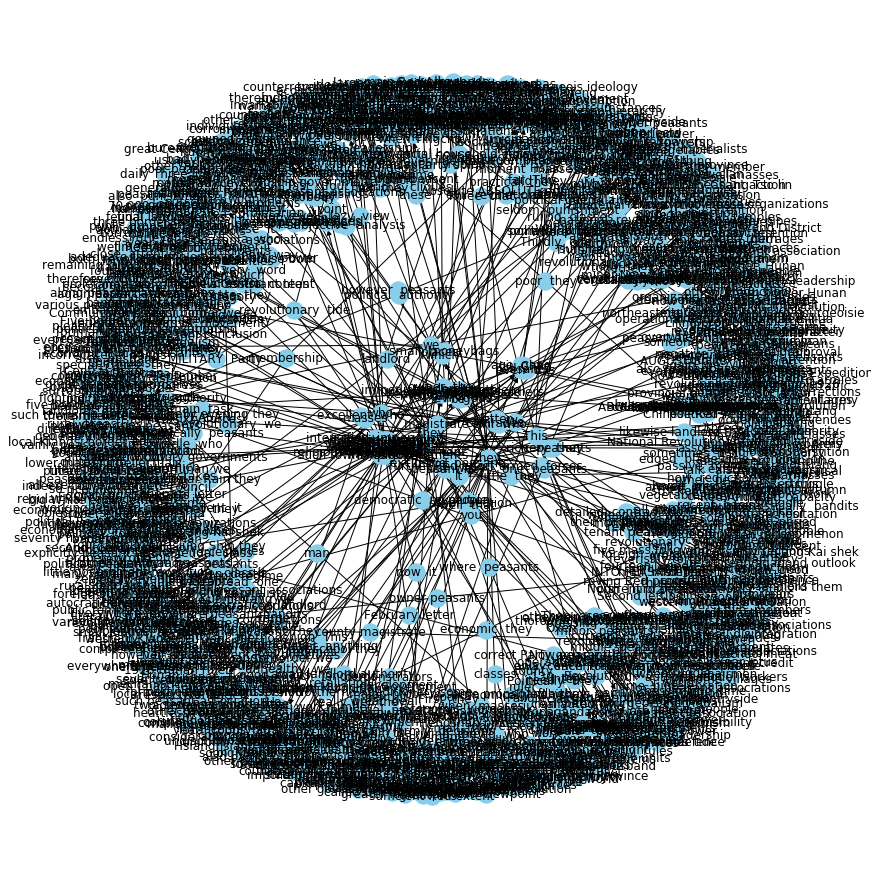

In [54]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Well, that's too much!

We have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.

So, it’s advisable to use only a few important relations to visualize a graph. I will take one relation at a time. Let’s start with the relation `is`:

In [55]:
G2 = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

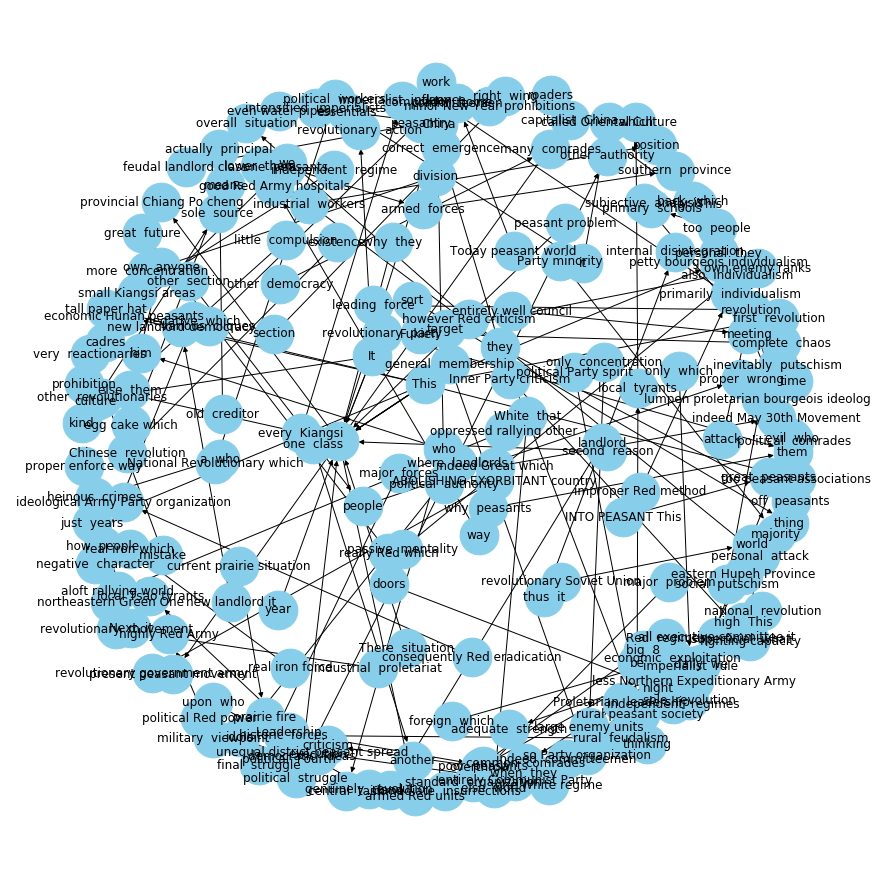

In [56]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G2, k = 0.5) # k regulates the distance between nodes
nx.draw(G2, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

That's better! Let's try `are`:

In [57]:
G3 = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="are"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

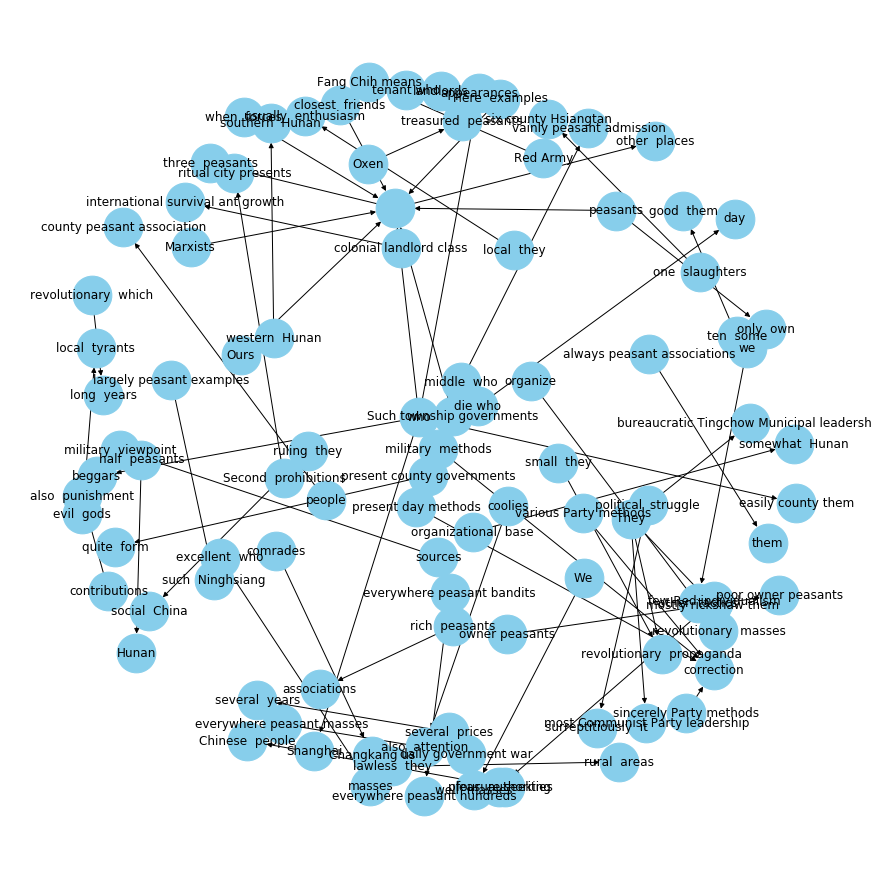

In [58]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G3, k = 0.5) # k regulates the distance between nodes
nx.draw(G3, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

And `was`:

In [59]:
G4 = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="was"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

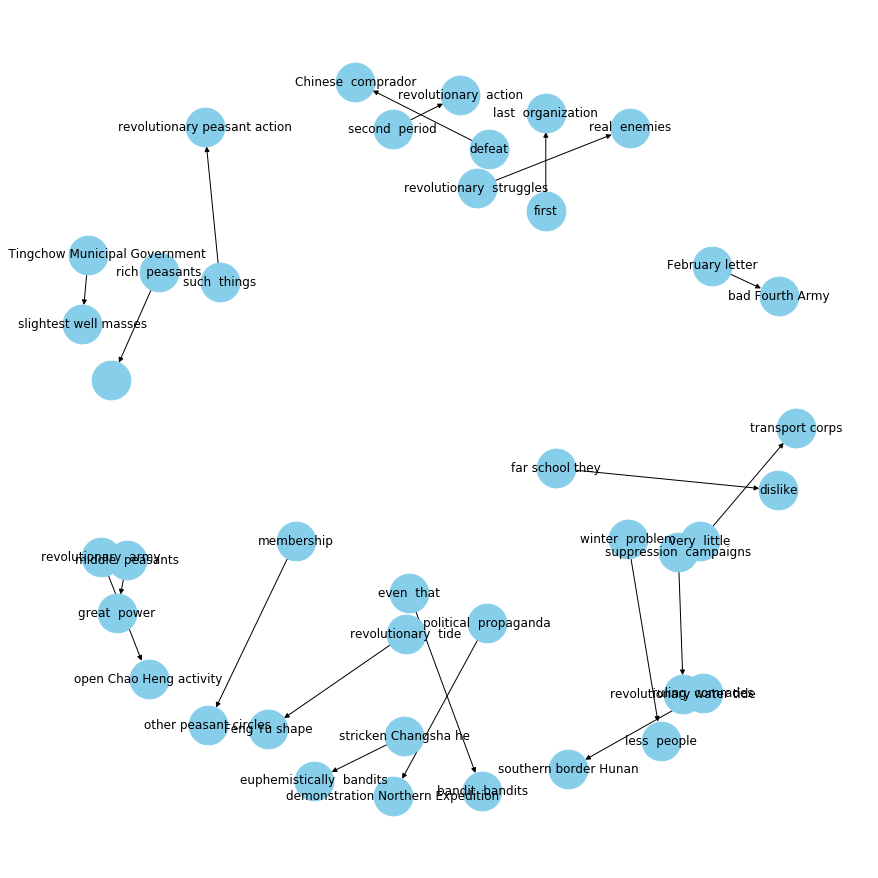

In [60]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G4, k = 0.5) # k regulates the distance between nodes
nx.draw(G4, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()